In [1]:
import fastai
from fastai import *
from fastai.text import *
from fastai.core import *
fastai.__version__

'1.0.51'

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook

import os
print(os.listdir("../input"))

['train_data.txt', 'test_data.txt']


# Data

In [3]:
train_df = pd.read_csv('../input/train_data.txt',  sep=':::', header=None, 
                       names=('name', 'genre', 'text'), index_col=0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [4]:
train_df.head()

,name,genre,text
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
name     54214 non-null object
genre    54214 non-null object
text     54214 non-null object
dtypes: object(3)
memory usage: 1.7+ MB


In [6]:
train_df.genre.value_counts()

 drama           13613
 documentary     13096
 comedy           7447
 short            5073
 horror           2204
 thriller         1591
 action           1315
 western          1032
 reality-tv        884
 family            784
 adventure         775
 music             731
 romance           672
 sci-fi            647
 adult             590
 crime             505
 animation         498
 sport             432
 talk-show         391
 fantasy           323
 mystery           319
 musical           277
 biography         265
 history           243
 game-show         194
 news              181
 war               132
Name: genre, dtype: int64

In [7]:
test_df = pd.read_csv('../input/test_data.txt',  sep=':::', header=None, 
                      names=('name', 'text'), index_col=0)
test_df.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,name,text
1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
5,Er nu zhai (1955),Before he was known internationally as a mart...


# Preprocessing

### Lower

In [8]:
train_df['text'] = train_df['text'].str.lower()
test_df['text'] = test_df['text'].str.lower()

### train_test_split

In [9]:
# split data into training and validation set
df_trn, df_val = train_test_split(train_df[['genre','text']], stratify = train_df['genre'], 
                                  test_size = 0.05, random_state = 42)
df_trn.shape, df_val.shape

((51503, 2), (2711, 2))

In [10]:
df_trn.head()

,genre,text
7123,short,"in the summer of 1996, darlie routier fell un..."
19951,documentary,a documentary history of lesbianism in north ...
17090,reality-tv,parker schnabel and his friends pay tribute t...
11464,documentary,documentary film recounting the travels of ca...
11017,sci-fi,a glowing brain-like creature arrives on a be...


# Encoder

In [11]:
# Language model data
data_lm = TextLMDataBunch.from_df('.', train_df=df_trn, valid_df=df_val)
data_lm.save('tmp_lm.pkl')

In [12]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


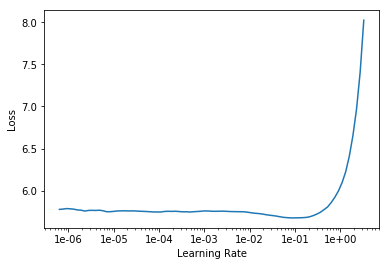

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.unfreeze()
learn.fit_one_cycle(3,)
learn.freeze()

epoch,train_loss,valid_loss,accuracy,time
0,4.806885,4.497121,0.269206,05:28


In [15]:
learn.save_encoder('ft_enc')

# Text Classification

In [16]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = '.', train_df=df_trn, valid_df=df_val, test_df=test_df,
                                      text_cols='text', label_cols='genre',
                                      vocab=data_lm.vocab, bs=32, shuffle = False,)
data_clas.save('tmp_DB.pkl')

In [17]:
data_clas

TextClasDataBunch;

Train: LabelList (51503 items)
x: TextList
xxbos in the summer of 1996 , darlie xxunk fell under the shadow of suspicion in the murder of her young sons . the media circled her like sharks , and , eventually , she was sentenced to death - row . 20 years later , doubt still remains . did darlie do it ? in a unique approach to true - crime , facts merge with opinions , mirroring the true confusion surrounding the haunting case . through all the speculation and theorizing , one thought remains : this was truly , an all - american murder .,xxbos a documentary history of lesbianism in north american and europe , with historic references , archival material , film clips , interviews with many women - famous and not - famous witnesses and players - who clearly remember a difficult , painful , and often downright dangerous past .,xxbos parker schnabel and his friends pay tribute to the legends before them and attempt the klondike trail of 1897 . not only is it 600 miles of 

In [18]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

### step-1

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


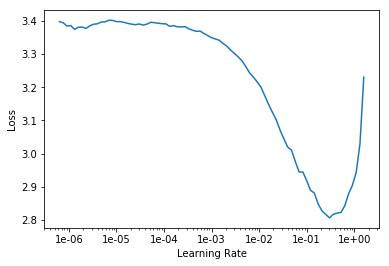

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(10, 1e-2)
learn.save('step-1')

epoch,train_loss,valid_loss,accuracy,time
0,1.536231,1.397415,0.564736,02:25
1,1.554794,1.367370,0.574696,02:20
2,1.485600,1.368569,0.562523,02:20
3,1.538699,1.346528,0.567687,02:23


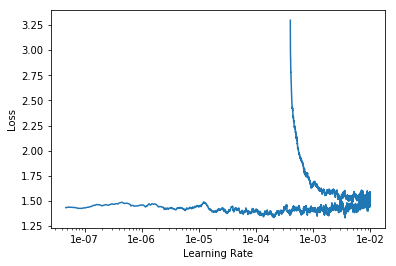

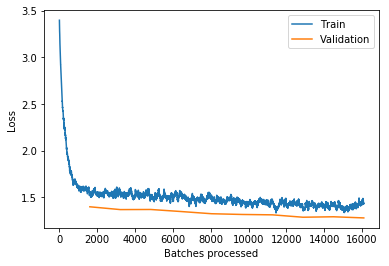

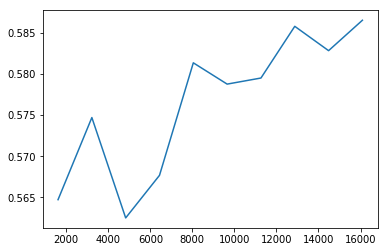

In [21]:
learn.recorder.plot()
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

### step-2

In [22]:
learn.freeze_to(-2)
learn.fit_one_cycle(10, slice(5e-3/2., 1e-3))
learn.freeze()
learn.save('step-2')

epoch,train_loss,valid_loss,accuracy,time
0,1.397211,1.259559,0.596828,02:39
1,1.416655,1.255859,0.599410,02:33
2,1.326303,1.251948,0.597565,02:54
3,1.327017,1.220460,0.608631,02:34


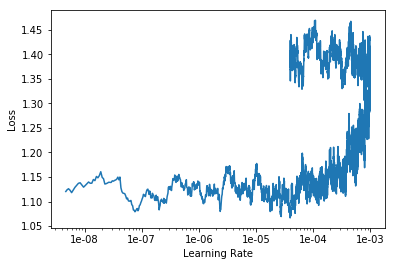

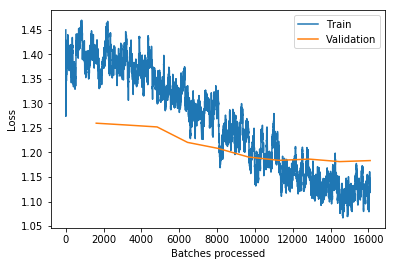

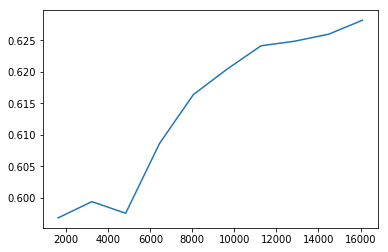

In [23]:
learn.recorder.plot()
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

### step-3

In [24]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/5, 1e-4))
learn.freeze()
learn.save('step-3')

epoch,train_loss,valid_loss,accuracy,time
0,1.125509,1.183123,0.629657,06:06
1,1.141699,1.176458,0.627444,05:48
2,1.046829,1.163864,0.637403,05:20


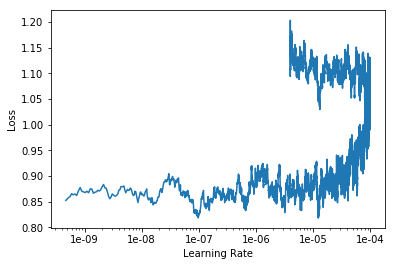

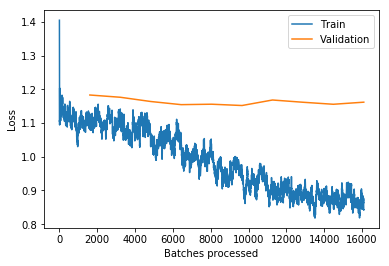

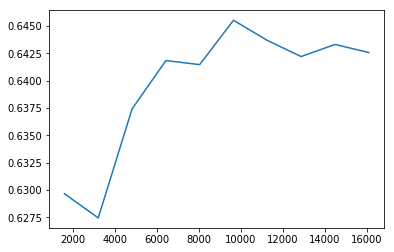

In [25]:
learn.recorder.plot()
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [26]:
learn.export()

# Predict & Submission

In [27]:
%%time
predict = []
predict_proba = []
for text in tqdm_notebook(test_df.text):
    predicts = learn.predict(text)
    predict.append(int(predicts[1]))
    predict_proba.append(np.array(predicts[2]))

In [28]:
predict_proba = pd.DataFrame(predict_proba)
predict_proba.columns = data_clas.classes
predict_proba.to_csv('predict_proba.csv', index=False)
predict_proba.head()

,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,family,fantasy,game-show,history,horror,music,musical,mystery,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,0.026403,6.998324e-05,0.002987,0.001134,0.000067,0.020459,2.330237e-02,0.000553,0.279686,0.000664,0.004428,6.103700e-06,0.000036,0.012318,0.000025,0.000169,1.852274e-02,4.129237e-06,0.000019,0.002563,0.008825,0.404329,0.000010,0.000001,0.193211,1.156399e-04,9.203483e-05
1,0.001036,1.508335e-04,0.001323,0.001687,0.000115,0.577820,9.841372e-04,0.001937,0.393790,0.013831,0.000106,5.344393e-07,0.000051,0.000161,0.000015,0.000263,2.223514e-04,7.127661e-07,0.000020,0.001352,0.000004,0.004475,0.000002,0.000002,0.000622,4.014358e-06,2.568210e-05
2,0.000003,5.377466e-07,0.000035,0.000003,0.000180,0.000064,5.839891e-07,0.993214,0.000462,0.000009,0.000002,1.095465e-08,0.000073,0.000003,0.000007,0.000001,3.926405e-07,3.761321e-06,0.000050,0.000001,0.000002,0.005877,0.000001,0.000001,0.000004,1.012595e-07,3.948776e-08
3,0.000809,1.885369e-04,0.002070,0.000405,0.001653,0.107247,1.577129e-03,0.025630,0.802577,0.003792,0.000461,2.446125e-06,0.000359,0.007571,0.000025,0.000375,1.403428e-03,1.792289e-05,0.000554,0.003364,0.000170,0.018372,0.000021,0.000036,0.021282,2.809882e-05,8.495282e-06
4,0.088770,1.774668e-06,0.000415,0.000500,0.001298,0.035501,1.511479e-02,0.001919,0.812361,0.005827,0.000489,3.430527e-06,0.001946,0.000911,0.000013,0.000277,2.473875e-03,2.476192e-05,0.000013,0.016151,0.000059,0.001377,0.000062,0.000041,0.014334,9.972488e-05,1.469823e-05


In [29]:
genre_sub=[]
for i in predict:
    genre_sub.append(data_clas.classes[i].replace(' ', ''))

submission = pd.DataFrame({'id':range(1, len(predict)+1), 'genre':genre_sub}, columns=['id', 'genre'])
submission.to_csv('submission.csv', index=False)
submission.head()

,id,genre
0,1,short
1,2,comedy
2,3,documentary
3,4,drama
4,5,drama


In [30]:
# v2